In [16]:
import torch
import numpy as np
import copy

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../helpers/")
sys.path.append("../helpers/utils")
sys.path.append("../helpers/central")
import utils
import sparse_linreg_peeling

torch.set_num_threads(1)
torch.set_printoptions(precision=32) # default

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Noise params

$\lambda = \eta_0 \cdot \frac{B}{n}$

$B \ge 4(R + c_0c_x) \cdot \frac{c_x}{\sqrt{s}}$

In [86]:
def compute_noise_scale(s, d, eta, n):
    # set constants
    c0 = 1
    cx = 1
    R = 1

    # compute B and lambda
    B = 4 * (R + cx * c0) * (cx / np.sqrt(s))
    lmb = eta * (B / n)
    return B, lmb

In [117]:
order = 3
d = 500
T = 1000
eta = 0.1
n = 1
result = {}

for i in [0.1, 0.2, 0.5]:
    k = int(i * d)
    # sample data
    data = utils.sample_dataset(n * (10 ** order), d, 0.05, k, 1)
    _, lmb = compute_noise_scale(k, d, eta, n * (10 ** order))

    # SLR non-private
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (_, _, _, False))
    result[(k, 'non-private')] = it_err
    print(f'[no noise] k={k}, last_err={last_err}')

    # SLR private
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (lmb, 1, 0.9, True)) # (0.0005, 0.9, 0.9)
    result[(k, 'private')] = it_err
    print(f'[with noise] k={k}, last_err={last_err}')

[no noise] k=50, last_err=0.04825862759575053
[with noise] k=50, last_err=0.0844205242860526
[no noise] k=100, last_err=0.039544308154077834
[with noise] k=100, last_err=0.08410325509995034
[no noise] k=250, last_err=0.05226794129740243
[with noise] k=250, last_err=0.10837291023044739


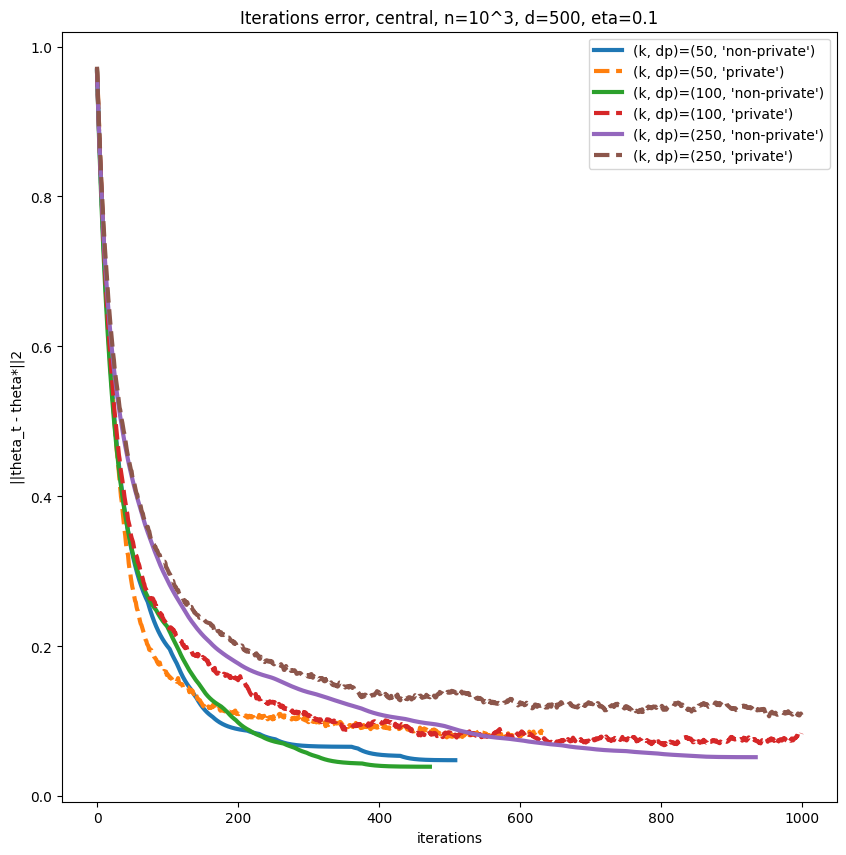

In [119]:
utils.plot_error_by_iteration_and_dict_key(
    result,
    title=f'Iterations error, central, n={n}0^{order}, d={d}, eta={eta}',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(k, dp)")